Brain Stroke Prediction CT Scan
Using Deep Learning (CNN)
Through TensorFlow / Keras

Cleaning The Dataset

In [1]:
import tensorflow as tf
import os
import cv2
import imghdr

DatasetDir = 'Dataset'

ImageExts = ['jpeg', 'jpg', 'bmp', 'png']

for ImageClass in os.listdir(DatasetDir): 
    for Image in os.listdir(os.path.join(DatasetDir, ImageClass)):
        ImagePath = os.path.join(DatasetDir, ImageClass, Image)
        try: 
            Img = cv2.imread(ImagePath)
            ImgExt = imghdr.what(ImagePath)
            if ImgExt not in ImageExts:
                print(f'This image is going to be deleted because it\'s extension is not compatible : {ImagePath}')
                os.remove(ImagePath)
        except Exception as e:
            print(f'Issue with image {ImagePath}')

C:\Users\asusg\AppData\Local\Temp\ipykernel_19572\3662017096.py:4: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


Loading the Dataset

In [2]:
import numpy as np
from matplotlib import pyplot as plt

Data = tf.keras.utils.image_dataset_from_directory('Dataset').map(lambda x,y: (x/255, y))

DataIterator = Data.as_numpy_iterator()

Batch = DataIterator.next()

Fig, ax = plt.subplots(ncols=4, figsize=(20,20))

for idx, img in enumerate(Batch[0][:4]):
    ax[idx].imshow(img.astype(float))
    ax[idx].title.set_text(Batch[1][idx])

Found 4829 files belonging to 2 classes.


Splitting The Data

In [3]:
training_size = int(len(Data)*.7)
validation_size = int(len(Data)*.2)+1
testing_size = int(len(Data)*.1)

print(f"training_size={training_size}")
print(f"validation_size={validation_size}")
print(f"testing_size={testing_size}")

training_size=105
validation_size=31
testing_size=15


In [4]:
TrainingData = Data.take(training_size)
ValidationData = Data.skip(training_size).take(validation_size)
TestingData = Data.skip(training_size+validation_size).take(testing_size)


The Deep Learning Model

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, RandomFlip, RandomRotation, RandomContrast

Model = Sequential()

Model.add(Conv2D(32, (3,3), activation='tanh', input_shape=(256,256,3)))  # Reduced number of Conv2D layers
Model.add(MaxPooling2D())
Model.add(Dropout(0.25))

# Removed additional Conv2D layers and their corresponding pooling and dropout layers

Model.add(Flatten())
Model.add(Dense(256, activation='tanh'))
Model.add(Dropout(0.5))

Model.add(Dense(1, activation='sigmoid'))

# Added learning rate to the Adam optimizer
Model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

Model.summary()


c:\Users\asusg\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 516128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │   132,129,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,130,177 (504.04 MB)

 Trainable params: 132,130,177 (504.04 MB)

 Non-trainable params: 0 (0.00 B)

Training the Model

In [6]:
LogDir='logs'
Tensorboard_Callback = tf.keras.callbacks.TensorBoard(log_dir=LogDir)
History = Model.fit(TrainingData, epochs=5, validation_data=ValidationData, callbacks=[Tensorboard_Callback])

Epoch 1/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 813ms/step - accuracy: 0.5461 - loss: 1.5621

Model Performance

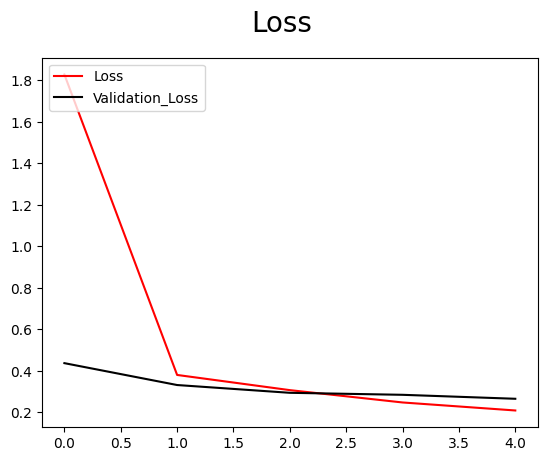

In [ ]:
Fig = plt.figure()
plt.plot(History.history['loss'], color='red', label='Loss')
plt.plot(History.history['val_loss'], color='black', label='Validation_Loss')
Fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

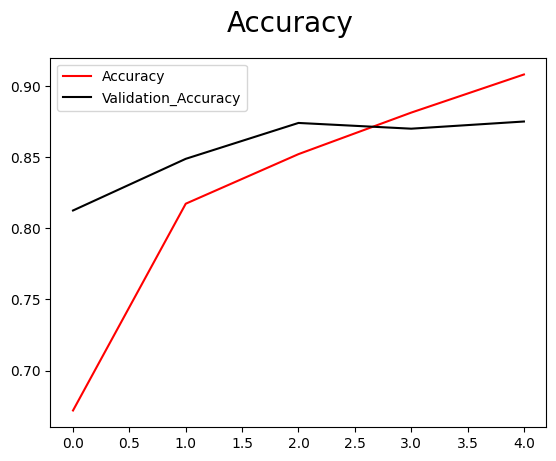

In [ ]:
Fig = plt.figure()
plt.plot(History.history['accuracy'], color='red', label='Accuracy')
plt.plot(History.history['val_accuracy'], color='black', label='Validation_Accuracy')
Fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

Evaluation

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize metrics
Precision = Precision()
Recall = Recall()
Accuracy = BinaryAccuracy()

# Initialize confusion matrix (assuming binary classification)
cm = np.zeros((2, 2))  # Adjust dimensions for multi-class problems

for Batch in TestingData.as_numpy_iterator():
  X, y = Batch
  yhat = Model.predict(X)

  # Update metrics
  Precision.update_state(y, yhat)
  Recall.update_state(y, yhat)
  Accuracy.update_state(y, yhat)

  # Calculate and accumulate confusion matrix
  cm += confusion_matrix(y, yhat.round())  # Round predictions for binary classes

# After iterating through all batches:

# Get final values for metrics
precision = Precision.result().numpy()
recall = Recall.result().numpy()
accuracy = Accuracy.result().numpy()

# Print or visualize the confusion matrix
print("Confusion Matrix:")
print(cm)

# Assuming you have class labels for your data
class_labels = ["Normal", "Stroke"]  # Adjust labels accordingly

# Get integer values for counts in the confusion matrix
cm_int = cm.astype(int)  # Convert to integer type

# Create a heatmap with integer annotations
sns.heatmap(cm_int, annot=True, fmt="d")  # Use 'd' format for integers
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
Confusion Matrix:
[[239.  15.]
 [ 47. 176.]]


In [ ]:
print(f"Precision : {Precision.result()}, Recall : {Recall.result()}, Accuracy : {Accuracy.result()}")

Precision : 0.9214659929275513, Recall : 0.7892376780509949, Accuracy : 0.8700209856033325


Testing the Model

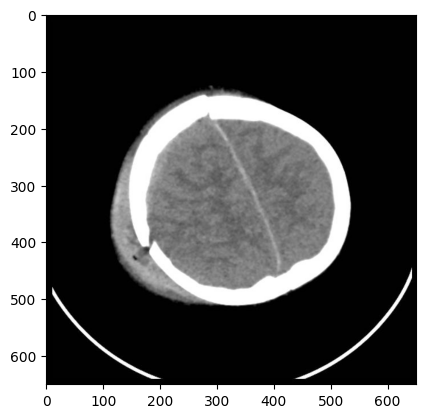

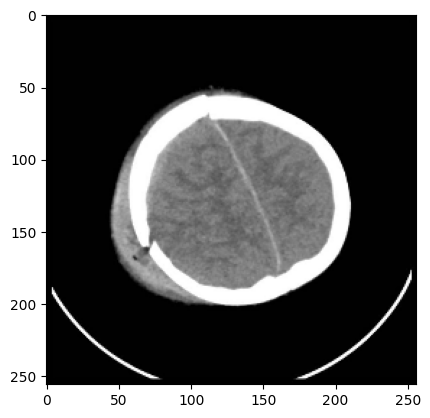

In [ ]:
import cv2

Img = cv2.imread('Dataset/Normal/51 (42).jpg')
plt.imshow(Img)
plt.show()

ResizedImg = tf.image.resize(Img, (256,256))
plt.imshow(ResizedImg.numpy().astype(int))
plt.show()

In [ ]:
yhat = Model.predict(np.expand_dims(ResizedImg/255, 0))

print(yhat)

if yhat > 0.5: 
    print(f'Predicted class is Stroke')
else:
    print(f'Predicted class is Normal')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
[[4.2615633e-05]]
Predicted class is Normal


In [ ]:
import cv2

Img = cv2.imread('Dataset/Stroke/2 (98).png')
plt.imshow(Img)
plt.show()

ResizedImg = tf.image.resize(Img, (256,256))
plt.imshow(ResizedImg.numpy().astype(int))
plt.show()

In [ ]:
yhat = Model.predict(np.expand_dims(ResizedImg/255, 0))
print(yhat)
if yhat > 0.5: 
    print(f'Predicted class is Stroke')
else:
    print(f'Predicted class is Normal')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[[0.2411161]]
Predicted class is Normal


Saving the Model

In [ ]:
from tensorflow.keras.models import load_model

Model.save(os.path.join('Models','ShallowBrainStrokeClassifier.keras'))
